## PHSX 815 Neural Network with Keras tutorial
### How can we predict the quality of wine based on its physical characteristics?
We will download the `wine_quality` dataset from Tensorflow (the Keras backend) to train a neural network to predict wine quality.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.activations import relu
import tensorflow_datasets as tfds
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pylab import rcParams
from sklearn import preprocessing

print("Lib loaded successfully !!")


Lib loaded successfully !!


**Loading Data**

In [2]:
# Loading the file in pandas dataFrame 
## Loading all data in four different pandas dataframe 
## Printing the data 
ipeds_df = pd.read_excel("IPEDS_data.xlsx")
print("University data loaded ...............")
ipeds_df.head()

University data loaded ...............


,ID number,Name,year,ZIP code,Highest degree offered,County name,Longitude location of institution,Latitude location of institution,Religious affiliation,Offers Less than one year certificate,Offers One but less than two years certificate,Offers Associate's degree,Offers Two but less than 4 years certificate,Offers Bachelor's degree,Offers Postbaccalaureate certificate,Offers Master's degree,Offers Post-master's certificate,Offers Doctor's degree - research/scholarship,Offers Doctor's degree - professional practice,Offers Doctor's degree - other,Offers Other degree,Applicants total,Admissions total,Enrolled total,Percent of freshmen submitting SAT scores,Percent of freshmen submitting ACT scores,SAT Critical Reading 25th percentile score,SAT Critical Reading 75th percentile score,SAT Math 25th percentile score,SAT Math 75th percentile score,SAT Writing 25th percentile score,SAT Writing 75th percentile score,ACT Composite 25th percentile score,ACT Composite 75th percentile score,"Estimated enrollment, total","Estimated enrollment, full time","Estimated enrollment, part time","Estimated undergraduate enrollment, total","Estimated undergraduate enrollment, full time","Estimated undergraduate enrollment, part time",...,Percent of undergraduate enrollment that are White,Percent of undergraduate enrollment that are two or more races,Percent of undergraduate enrollment that are Race/ethnicity unknown,Percent of undergraduate enrollment that are Nonresident Alien,Percent of undergraduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of undergraduate enrollment that are women,Percent of graduate enrollment that are American Indian or Alaska Native,Percent of graduate enrollment that are Asian,Percent of graduate enrollment that are Black or African American,Percent of graduate enrollment that are Hispanic/Latino,Percent of graduate enrollment that are Native Hawaiian or Other Pacific Islander,Percent of graduate enrollment that are White,Percent of graduate enrollment that are two or more races,Percent of graduate enrollment that are Race/ethnicity unknown,Percent of graduate enrollment that are Nonresident Alien,Percent of graduate enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of graduate enrollment that are women,Number of first-time undergraduates - in-state,Percent of first-time undergraduates - in-state,Number of first-time undergraduates - out-of-state,Percent of first-time undergraduates - out-of-state,Number of first-time undergraduates - foreign countries,Percent of first-time undergraduates - foreign countries,Number of first-time undergraduates - residence unknown,Percent of first-time undergraduates - residence unknown,"Graduation rate - Bachelor degree within 4 years, total","Graduation rate - Bachelor degree within 5 years, total","Graduation rate - Bachelor degree within 6 years, total",Percent of freshmen receiving any financial aid,"Percent of freshmen receiving federal, state, local or institutional grant aid",Percent of freshmen receiving federal grant aid,Percent of freshmen receiving Pell grants,Percent of freshmen receiving other federal grant aid,Percent of freshmen receiving state/local grant aid,Percent of freshmen receiving institutional grant aid,Percent of freshmen receiving student loan aid,Percent of freshmen receiving federal student loans,Percent of freshmen receiving other loan aid,Endowment assets (year end) per FTE enrollment (GASB),Endowment assets (year end) per FTE enrollment (FASB)
0,100654,Alabama A & M University,2013,35762,Doctor's degree - research/scholarship,Madison County,-86.568502,34.783368,Not applicable,Implied no,Implied no,Implied no,Implied no,Yes,Implied no,Yes,Implied no,Yes,Implied no,Implied no,Implied no,6142.0,5521.0,1104.0,15.0,88.0,370.0,450.0,350.0,450.0,NaN,NaN,15.0,19.0,5024.0,4442.0,582.0,4055.0,3802.0,253.0,...,3.0,0.0,1.0,0.0,0.0,51.0,0.0,2.0,81.0,1.0,0.0,15.0,0.0,1.0,0.0,2.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,23.0,29.0,9

**2. Data Analysis**

In [3]:
# Looking into the data columns we have;
for col in ipeds_df.columns:
  print(col)

ID number
Name
year
ZIP code
Highest degree offered
County name
Longitude location of institution
Latitude location of institution
Religious affiliation
Offers Less than one year certificate
Offers One but less than two years certificate
Offers Associate's degree
Offers Two but less than 4 years certificate
Offers Bachelor's degree
Offers Postbaccalaureate certificate
Offers Master's degree
Offers Post-master's certificate
Offers Doctor's degree - research/scholarship
Offers Doctor's degree - professional practice
Offers Doctor's degree - other
Offers Other degree
Applicants total
Admissions total
Enrolled total
Percent of freshmen submitting SAT scores
Percent of freshmen submitting ACT scores
SAT Critical Reading 25th percentile score
SAT Critical Reading 75th percentile score
SAT Math 25th percentile score
SAT Math 75th percentile score
SAT Writing 25th percentile score
SAT Writing 75th percentile score
ACT Composite 25th percentile score
ACT Composite 75th percentile score
Estimate

**3. Data Visualization**

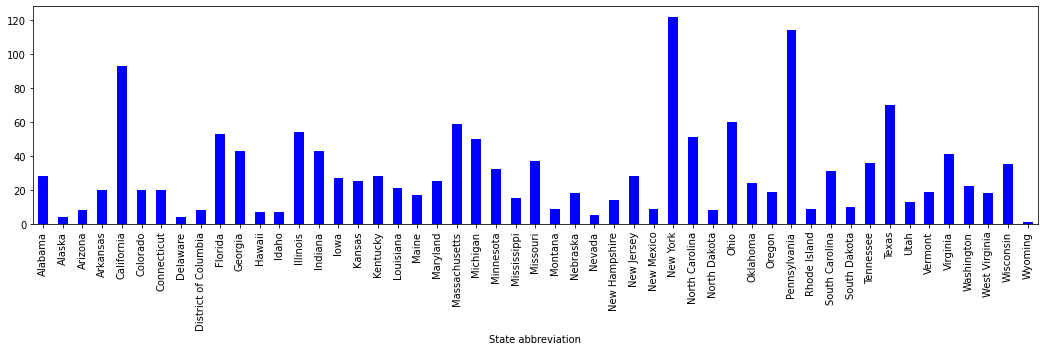

In [5]:
# Number of Universities by State 
uni_by_state = ipeds_df.groupby('State abbreviation')['Name'].count()
uni_by_state.plot.bar(color = 'Blue',figsize=(18, 4))

**4. Preprocessing**
Preprocessig in terms of predicting the total number of applicants. The proprocessing module will define number of features (feature selection), correction 



In [6]:
# Checking total size of df 
ipeds_df.shape

(1534, 145)

In [7]:
# Checking data in the Null Not Available etc. 
ipeds_df.isnull().sum(axis = 0)

ID number                                                   0
Name                                                        0
year                                                        0
ZIP code                                                    0
Highest degree offered                                      0
                                                         ... 
Percent of freshmen receiving student loan aid             42
Percent of freshmen receiving federal student loans        42
Percent of freshmen receiving other loan aid               42
Endowment assets (year end) per FTE enrollment (GASB)    1018
Endowment assets (year end) per FTE enrollment (FASB)     574
Length: 145, dtype: int64

In [5]:
# From domain understanding some of the colums are not related to the target (label) varibales. 
# Lets filter them out 

cols_to_filter = ['Name',
                  'Religious affiliation',
                  'Applicants total'
                  ,'Admissions total',
                  'State abbreviation',
                  'Historically Black College or University',
                  'Percent of total enrollment that are Asian',
                  'Percent of total enrollment that are Black or African American',
                  'Percent of total enrollment that are Hispanic/Latino',
                  'Percent of total enrollment that are White',
                  'Percent of freshmen receiving federal, state, local or institutional grant aid',
                  'Percent of total enrollment that are women']
t_admission_df = ipeds_df[cols_to_filter]
t_admission_df.head()

,Name,Religious affiliation,Applicants total,Admissions total,State abbreviation,Historically Black College or University,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are White,"Percent of freshmen receiving federal, state, local or institutional grant aid",Percent of total enrollment that are women
0,Alabama A & M University,Not applicable,6142.0,5521.0,Alabama,Yes,1.0,92.0,1.0,5.0,89.0,55.0
1,University of Alabama at Birmingham,Not applicable,5689.0,4934.0,Alabama,No,5.0,21.0,3.0,64.0,79.0,61.0
2,Amridge University,Churches of Christ,NaN,NaN,Alabama,No,0.0,40.0,1.0,30.0,90.0,58.0
3,University of Alabama in Huntsville,Not applicable,2054.0,1656.0,Alabama,No,4.0,12.0,3.0,69.0,77.0,44.0
4,Alabama State University,Not applicable,10245.0,5251.0,Alabama,Yes,0.0,91.0,1.0,3.0,87.0,61.0


In [11]:
# Checking Null data 
t_admission_df.isnull().sum(axis = 0)

Name                                                                                0
Religious affiliation                                                               2
Applicants total                                                                  157
Admissions total                                                                  157
State abbreviation                                                                  0
Historically Black College or University                                            0
Percent of total enrollment that are Asian                                          2
Percent of total enrollment that are Black or African American                      2
Percent of total enrollment that are Hispanic/Latino                                2
Percent of total enrollment that are White                                          2
Percent of freshmen receiving federal, state, local or institutional grant aid     42
Percent of total enrollment that are women            

In [16]:
t_admission_df = t_admission_df.dropna(axis=0)
t_admission_df.isnull().sum(axis = 0)
t_admission_df.shape

Name                                                                              0
Religious affiliation                                                             0
Applicants total                                                                  0
Admissions total                                                                  0
State abbreviation                                                                0
Historically Black College or University                                          0
Percent of total enrollment that are Asian                                        0
Percent of total enrollment that are Black or African American                    0
Percent of total enrollment that are Hispanic/Latino                              0
Percent of total enrollment that are White                                        0
Percent of freshmen receiving federal, state, local or institutional grant aid    0
Percent of total enrollment that are women                                  

(1373, 12)

In [63]:
# Label Encoding
le = preprocessing.LabelEncoder()
t_admission_df['Religious affiliation'] = le.fit_transform(t_admission_df['Religious affiliation'] )
t_admission_df['State abbreviation'] = le.fit_transform(t_admission_df['State abbreviation'] )
t_admission_df['Historically Black College or University'] = le.fit_transform(t_admission_df['Historically Black College or University'] )
t_admission_df['Name'] = le.fit_transform(t_admission_df['Name'] )

t_admission_df.head()

,Name,Religious affiliation,Applicants total,Admissions total,State abbreviation,Historically Black College or University,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are White,"Percent of freshmen receiving federal, state, local or institutional grant aid",Percent of total enrollment that are women
0,5,33,6142.0,5521.0,0,1,1.0,92.0,1.0,5.0,89.0,55.0
1,1076,33,5689.0,4934.0,0,0,5.0,21.0,3.0,64.0,79.0,61.0
3,1077,33,2054.0,1656.0,0,0,4.0,12.0,3.0,69.0,77.0,44.0
4,6,33,10245.0,5251.0,0,1,0.0,91.0,1.0,3.0,87.0,61.0
5,1027,33,30975.0,17515.0,0,0,1.0,11.0,3.0,77.0,60.0,55.0


In [64]:
# Lets plot a correlation heatmap 
def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 20,20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="YlGnBu")
    plt.show()
    fig.savefig('corr.png')

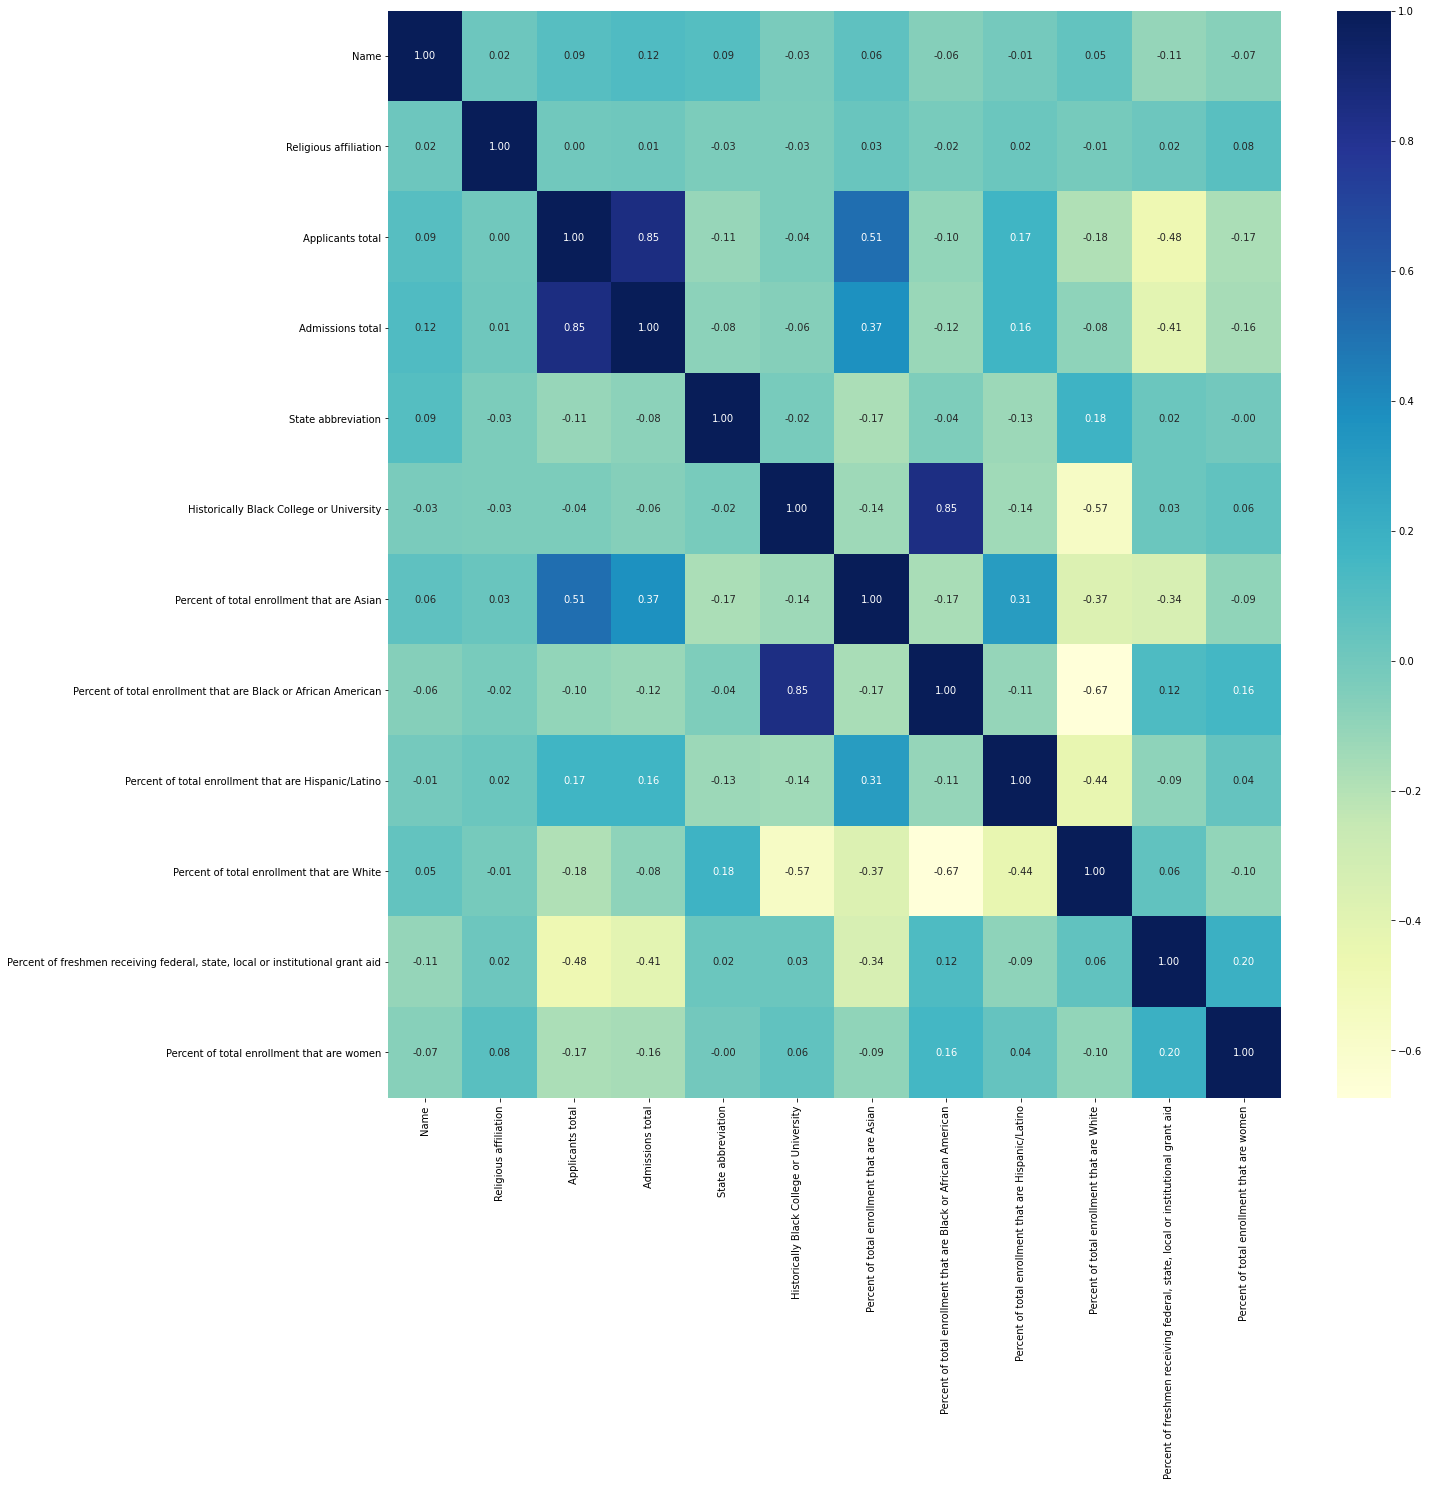

In [65]:
plot_correlation(t_admission_df)

In [66]:
t_admission_df.head()

,Name,Religious affiliation,Applicants total,Admissions total,State abbreviation,Historically Black College or University,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are White,"Percent of freshmen receiving federal, state, local or institutional grant aid",Percent of total enrollment that are women
0,5,33,6142.0,5521.0,0,1,1.0,92.0,1.0,5.0,89.0,55.0
1,1076,33,5689.0,4934.0,0,0,5.0,21.0,3.0,64.0,79.0,61.0
3,1077,33,2054.0,1656.0,0,0,4.0,12.0,3.0,69.0,77.0,44.0
4,6,33,10245.0,5251.0,0,1,0.0,91.0,1.0,3.0,87.0,61.0
5,1027,33,30975.0,17515.0,0,0,1.0,11.0,3.0,77.0,60.0,55.0


**4 . Learning From data**

In [67]:
# Test Train Separation
feature_cols = [   'Name',
                  'Religious affiliation',
                  'Applicants total',
                  'State abbreviation',
                  'Historically Black College or University',
                  'Percent of total enrollment that are Asian',
                  'Percent of total enrollment that are Black or African American',
                  'Percent of total enrollment that are Hispanic/Latino',
                  'Percent of total enrollment that are White',
                  'Percent of freshmen receiving federal, state, local or institutional grant aid',
                  'Percent of total enrollment that are women']
target_cols = ['Admissions total']
# Y is target 
# X is feature vector
x_train, x_test, y_train, y_test = train_test_split(t_admission_df[feature_cols], t_admission_df[target_cols],test_size=0.3)
x_train.head() 

,Name,Religious affiliation,Applicants total,State abbreviation,Historically Black College or University,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are White,"Percent of freshmen receiving federal, state, local or institutional grant aid",Percent of total enrollment that are women
1056,1281,13,948.0,37,0,5.0,9.0,11.0,59.0,93.0,56.0
318,703,18,3961.0,13,0,6.0,10.0,15.0,51.0,98.0,64.0
220,841,33,4729.0,9,0,3.0,6.0,15.0,64.0,85.0,59.0
1328,111,25,11423.0,44,0,2.0,0.0,6.0,83.0,49.0,45.0
791,218,33,8374.0,32,0,3.0,4.0,8.0,68.0,41.0,55.0


In [91]:
y_train.head()
nClasses = y_train.shape
print (nClasses)

,Admissions total
1056,500.0
318,2073.0
220,2785.0
1328,5645.0
791,2209.0


(961, 1)


Creation of the model

In [102]:
# Model
nClasses = y_train.shape[0]
model = Sequential()
model.add(Input(shape=(len(feature_cols),)))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
#model.add(Dense(nClasses,activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_48 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_49 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
Total params: 51,072
Trainable params: 51,072
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Fitting
history = model.fit(x_train, y_train, validation_split=0.1, verbose=1, epochs=100, batch_size=64, shuffle=True)

Epoch 1/100
14/14 [==============================] - 1s 19ms/step - loss: 27577722.6667 - val_loss: 15516028.0000
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 17505465.3333 - val_loss: 11679950.0000
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 11852648.7667 - val_loss: 10532276.0000
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 12266590.0667 - val_loss: 11066424.0000
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 13293930.4000 - val_loss: 9912139.0000
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 11422095.8333 - val_loss: 10490540.0000
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 11117630.2000 - val_loss: 8898286.0000
Epoch 8/100
14/14 [==============================] - 0s 6ms/step - loss: 9605182.6000 - val_loss: 9389061.0000
Epoch 9/100
14/14 [==============================] - 0s 6ms/step - loss: 9358089.3667 - val_loss: 7

In [104]:
y_predicted = model.predict(x_test)


In [105]:
print(y_predicted)
print(y_test)


[[1651.6581  1621.7598  1640.9602  ... 1626.9117  1639.5288  1664.474  ]
 [1645.2571  1658.7588  1639.5322  ... 1638.138   1659.4862  1662.0415 ]
 [ 704.1351   730.8815   733.3961  ...  736.9085   754.81934  744.3085 ]
 ...
 [8411.717   8336.829   8447.321   ... 8503.843   8413.085   8497.849  ]
 [5352.903   5337.7085  5310.6743  ... 5389.4907  5370.7324  5342.4233 ]
 [2735.805   2763.4448  2694.6372  ... 2751.3333  2775.4976  2745.5183 ]]
      Admissions total
523             1614.0
96              1800.0
109              521.0
575             2657.0
1281             736.0
...                ...
776              450.0
282              757.0
131             7344.0
279             4894.0
395             2517.0

[412 rows x 1 columns]


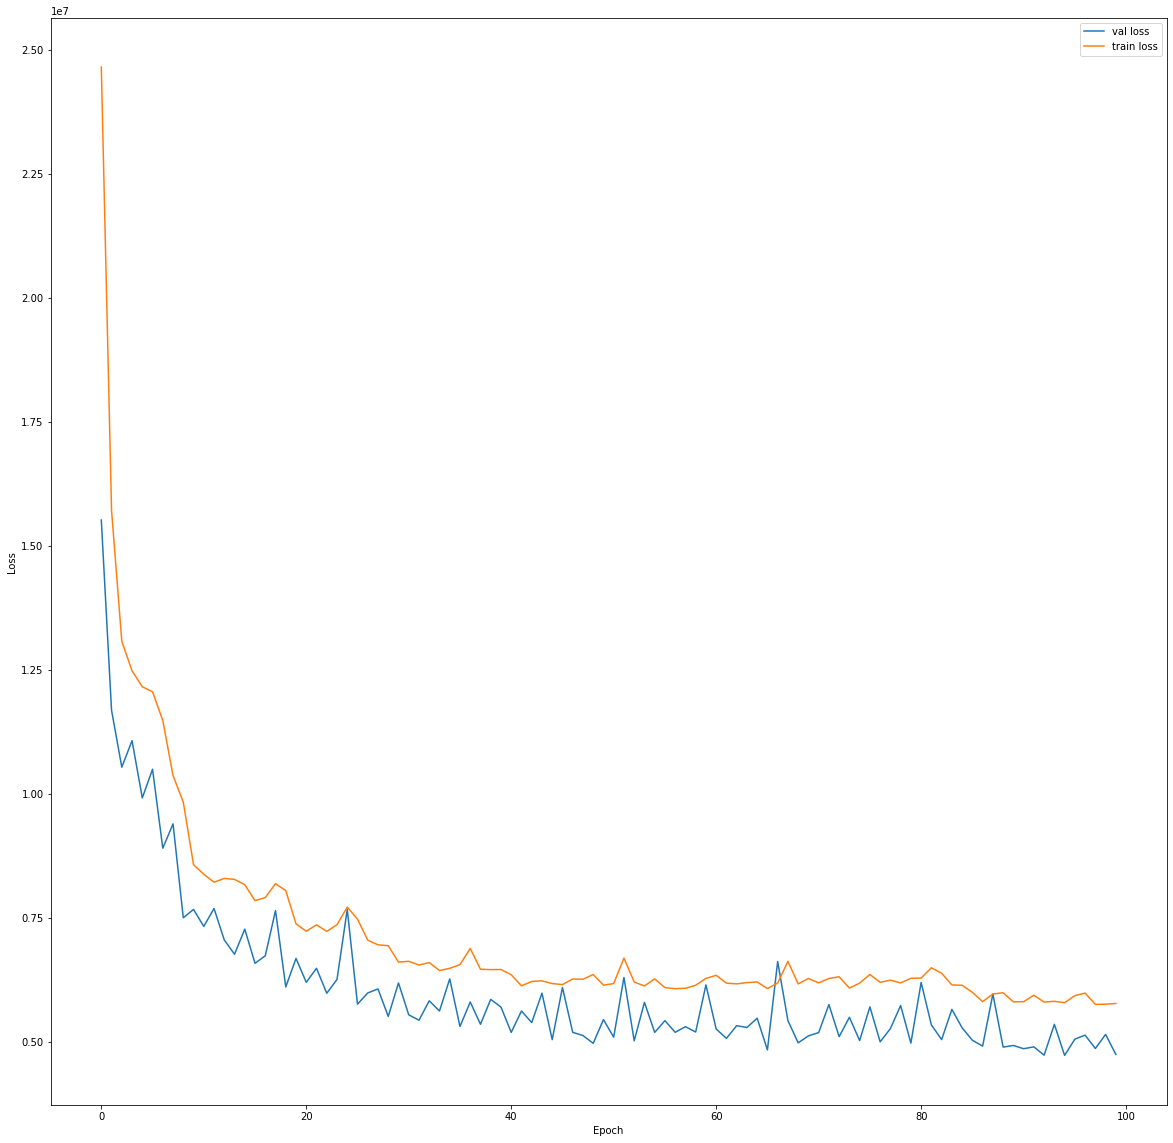

In [107]:
def show_loss(history):
    plt.figure()
    plt.plot(history.history['val_loss'], label="val loss")
    plt.plot(history.history['loss'],label="train loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
show_loss(history)

To plot our results, I just chose the highest probability of the classes and assigned the prediction to a class based on that rounding (highest probability gets a 1, every other class gets a 0). Then, I one-hot decoded the rounded array to get a single number for the class. 

In [108]:
#preds = model.predict(df_test)
#preds = [i.round() for i in preds]
y_predicted = tf.one_hot(tf.math.argmax(y_predicted,axis =1),depth = len(y_predicted[0]))

y_predicted = enc.inverse_transform(y_predicted)
testLabels = enc.inverse_transform(y_test)
cm = confusion_matrix(testLabels, y_predicted)

_ =plt.imshow(cm, cmap=plt.cm.Blues)
_ = plt.xlabel("Predicted labels")
_ = plt.ylabel("True labels")

_ =plt.xticks(np.arange(0,len(np.unique(testLabels)),1),np.unique(testLabels))
_ =plt.yticks(np.arange(0,len(np.unique(testLabels)),1),np.unique(testLabels))
_ =plt.title('Confusion matrix ')
_ =plt.colorbar()
plt.show()

NameError: ignored

### Overall, 
our network performs ok with a training, validation, and test accuracy all around 50-60%. What could you change about the network or inputs? How do you think that would affect the model's predictions?




I could change number of layers in the network or slice the test and training data differently. I would think incresing number of layer will definately increase the accuracy of the validation. 
